In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random 
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# os.chdir(r'D:\senior year\GP\datasets\ragaadataset\AFULL-CLASSES\dividing 106 classes 8020')
# if os.path.isdir('train/0/') is False:
#     os.mkdir('train')
#     #os.mkdir('valid')
#     os.mkdir('test')

#     for i in range(0,106): #number of classes
#         shutil.move(f'{i}','train')
# #         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')

# #         valid_samples = random.sample(os.listdir(f'train/{i}'),100) #100 sore mnn al train to valid from every class(100*10)
# #         for j in valid_samples:
# #             shutil.move(f'train/{i}/{j}', f'valid/{i}')
#         print(int((len(f'train/{i}')*20)/100))
#         test_samples = random.sample(os.listdir(f'train/{i}'),int((len(f'train/{i}')*20)/100)) #50 sora mn al train to test ly kol class
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('../..')


In [3]:
# import cv2 
# import os 
# import glob 
# import numpy as np
# import matplotlib.pyplot as plt 
# from skimage.filters import threshold_otsu

# for i in range(0,10):
#     image_directory = 'D:\senior year\GP\datasets\ragaadataset\AFULL-CLASSES\10 classes with validation\train\{i}'
#     images_path = os.path.join(image_directory, '*g')
#     files = glob.glob(images_path)
#     ostu_images = []
#     for image in files:
#         img = cv2.imread(image)
#         b,g,r = cv2.split(img)
#         rgb_img = cv2.merge([r,g,b])
#         gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#         ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
#         #remove noise
#         kernel = np.ones((2,2), np.uint8)
#         closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
#         # sure background area
#         sure_bg = cv2.dilate(closing,kernel,iterations=3)
#         # Finding sure foreground area
#         dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
#         # Threshold
#         ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
#         # Finding unknown region
#         sure_fg = np.uint8(sure_fg)
#         unknown = cv2.subtract(sure_bg,sure_fg)
#         # Marker labelling
#         ret, markers = cv2.connectedComponents(sure_fg)
#         # Add one to all labels so that sure background is not 0, but 1
#         markers = markers+1
#         # Now, mark the region of unknown with zero
#         markers[unknown==255] = 0
#         markers = cv2.watershed(img,markers)
#         img[markers == -1] = [255,0,0]
#         ostu_images.append(thresh)
#         plt.imshow(thresh, 'gray')
#         plt.show()

In [4]:
train_path = r'D:\senior year\GP\datasets\ragaadataset\AFULL-CLASSES\dividing 106 classes 8020\train'
# valid_path = r'D:\senior year\GP\datasets\ragaadataset\AFULL-CLASSES\10 classes with validation\valid'
test_path = r'D:\senior year\GP\datasets\ragaadataset\AFULL-CLASSES\dividing 106 classes 8020\test'

#print('total dataset is 4220 image:')
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, 
    target_size=(224,224),
    batch_size=10)

# valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
#     directory=valid_path,
#     target_size=(224,224), 
#     batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    batch_size=10, 
    shuffle=False)

Found 2585 images belonging to 106 classes.
Found 651 images belonging to 106 classes.


In [5]:
mobile= tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [6]:
x = mobile.layers[-6].output #hakhod al hidden layers mn mobile kolo ela akher 6
x

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1024) dtype=float32>

In [7]:
output =  Dense(units=106, activation ='softmax')(x)
#dense new hidden layer

In [8]:
model = Model(inputs=mobile.input, outputs=output) #new model x + dense layer

In [9]:
for layer in model.layers[:-23]: #only train the last 23 layers in our new model
    layer.trainable=False 

In [10]:
model.summary() #our new model (model-6 + dense)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [11]:
model.compile(optimizer=Adam(lr=0.0100), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
import time

start = time.time()
history = model.fit(x=train_batches,
#          steps_per_epoch=len(train_batches), #no batch size, kol epoch btakhod kol al train images
                     batch_size=128,
#          validation_data=valid_batches,
#          validation_steps=len(valid_batches),
         epochs=30,
         verbose=2)
stop = time.time()
print(f"Training time: {(stop - start)/60}min")
#val watya acc 3alya = overfitting

Epoch 1/30
259/259 - 74s - loss: 2.2753 - accuracy: 0.5373
Epoch 2/30
259/259 - 76s - loss: 1.0537 - accuracy: 0.7284
Epoch 3/30
259/259 - 77s - loss: 0.7252 - accuracy: 0.7988
Epoch 4/30
259/259 - 77s - loss: 0.5017 - accuracy: 0.8499
Epoch 5/30
259/259 - 79s - loss: 0.3565 - accuracy: 0.8990
Epoch 6/30
259/259 - 79s - loss: 0.3079 - accuracy: 0.8994
Epoch 7/30
259/259 - 79s - loss: 0.2311 - accuracy: 0.9354
Epoch 8/30
259/259 - 80s - loss: 0.1862 - accuracy: 0.9366
Epoch 9/30
259/259 - 80s - loss: 0.1370 - accuracy: 0.9559
Epoch 10/30
259/259 - 81s - loss: 0.1614 - accuracy: 0.9509
Epoch 11/30
259/259 - 80s - loss: 0.1278 - accuracy: 0.9687
Epoch 12/30
259/259 - 80s - loss: 0.1153 - accuracy: 0.9648
Epoch 13/30
259/259 - 81s - loss: 0.1199 - accuracy: 0.9660
Epoch 14/30
259/259 - 81s - loss: 0.1136 - accuracy: 0.9706
Epoch 15/30
259/259 - 81s - loss: 0.0538 - accuracy: 0.9865
Epoch 16/30
259/259 - 81s - loss: 0.0983 - accuracy: 0.9729
Epoch 17/30
259/259 - 81s - loss: 0.0963 - accura

In [13]:
test_labels = test_batches.classes
test_labels

array([  0,   1,   1,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   3,   4,   4,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   6,   7,   7,   7,   8,   8,   8,   8,   8,   8,   8,   8,
         8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   9,
        10,  11,  12,  12,  12,  12,  12,  12,  12,  13,  14,  15,  15,
        15,  15,  16,  16,  16,  17,  17,  17,  18,  18,  18,  18,  19,
        20,  21,  22,  22,  22,  22,  22,  22,  22,  22,  22,  22,  22,
        23,  23,  23,  23,  23,  24,  24,  24,  25,  25,  25,  25,  26,
        26,  26,  26,  27,  27,  28,  28,  28,  28,  28,  29,  29,  29,
        30,  30,  31,  32,  33,  34,  34,  34,  34,  34,  34,  34,  34,
        34,  34,  34,  34,  34,  34,  34,  34,  34,  34,  34,  3

In [14]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)


In [15]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
cm

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 9, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int64)

In [16]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    #this function prints and plots the confusion matrix
    plt.figure(figsize = (50,50))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("normalized confusion matrix")
    else:
        print('confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], 
                horizontalalignment = "center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('true/real label')
    plt.xlabel('predicted label')

In [17]:
test_batches.class_indices

{'000': 0,
 '001': 1,
 '002': 2,
 '003': 3,
 '004': 4,
 '005': 5,
 '006': 6,
 '007': 7,
 '008': 8,
 '009': 9,
 '010': 10,
 '011': 11,
 '012': 12,
 '013': 13,
 '014': 14,
 '015': 15,
 '016': 16,
 '017': 17,
 '018': 18,
 '019': 19,
 '020': 20,
 '021': 21,
 '022': 22,
 '023': 23,
 '024': 24,
 '025': 25,
 '026': 26,
 '027': 27,
 '028': 28,
 '029': 29,
 '030': 30,
 '031': 31,
 '032': 32,
 '033': 33,
 '034': 34,
 '035': 35,
 '036': 36,
 '037': 37,
 '038': 38,
 '039': 39,
 '040': 40,
 '041': 41,
 '042': 42,
 '043': 43,
 '044': 44,
 '045': 45,
 '046': 46,
 '047': 47,
 '048': 48,
 '049': 49,
 '050': 50,
 '051': 51,
 '052': 52,
 '053': 53,
 '054': 54,
 '055': 55,
 '056': 56,
 '057': 57,
 '058': 58,
 '059': 59,
 '060': 60,
 '061': 61,
 '062': 62,
 '063': 63,
 '064': 64,
 '065': 65,
 '066': 66,
 '067': 67,
 '068': 68,
 '069': 69,
 '070': 70,
 '071': 71,
 '072': 72,
 '073': 73,
 '074': 74,
 '075': 75,
 '076': 76,
 '077': 77,
 '078': 78,
 '079': 79,
 '080': 80,
 '081': 81,
 '082': 82,
 '083': 83,
 '

In [18]:
number_of_classes = 106
cm_plot_labels = []
for i in range(0, number_of_classes):
    cm_plot_labels.append(i)
    
print(cm_plot_labels)    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]


confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 4]]


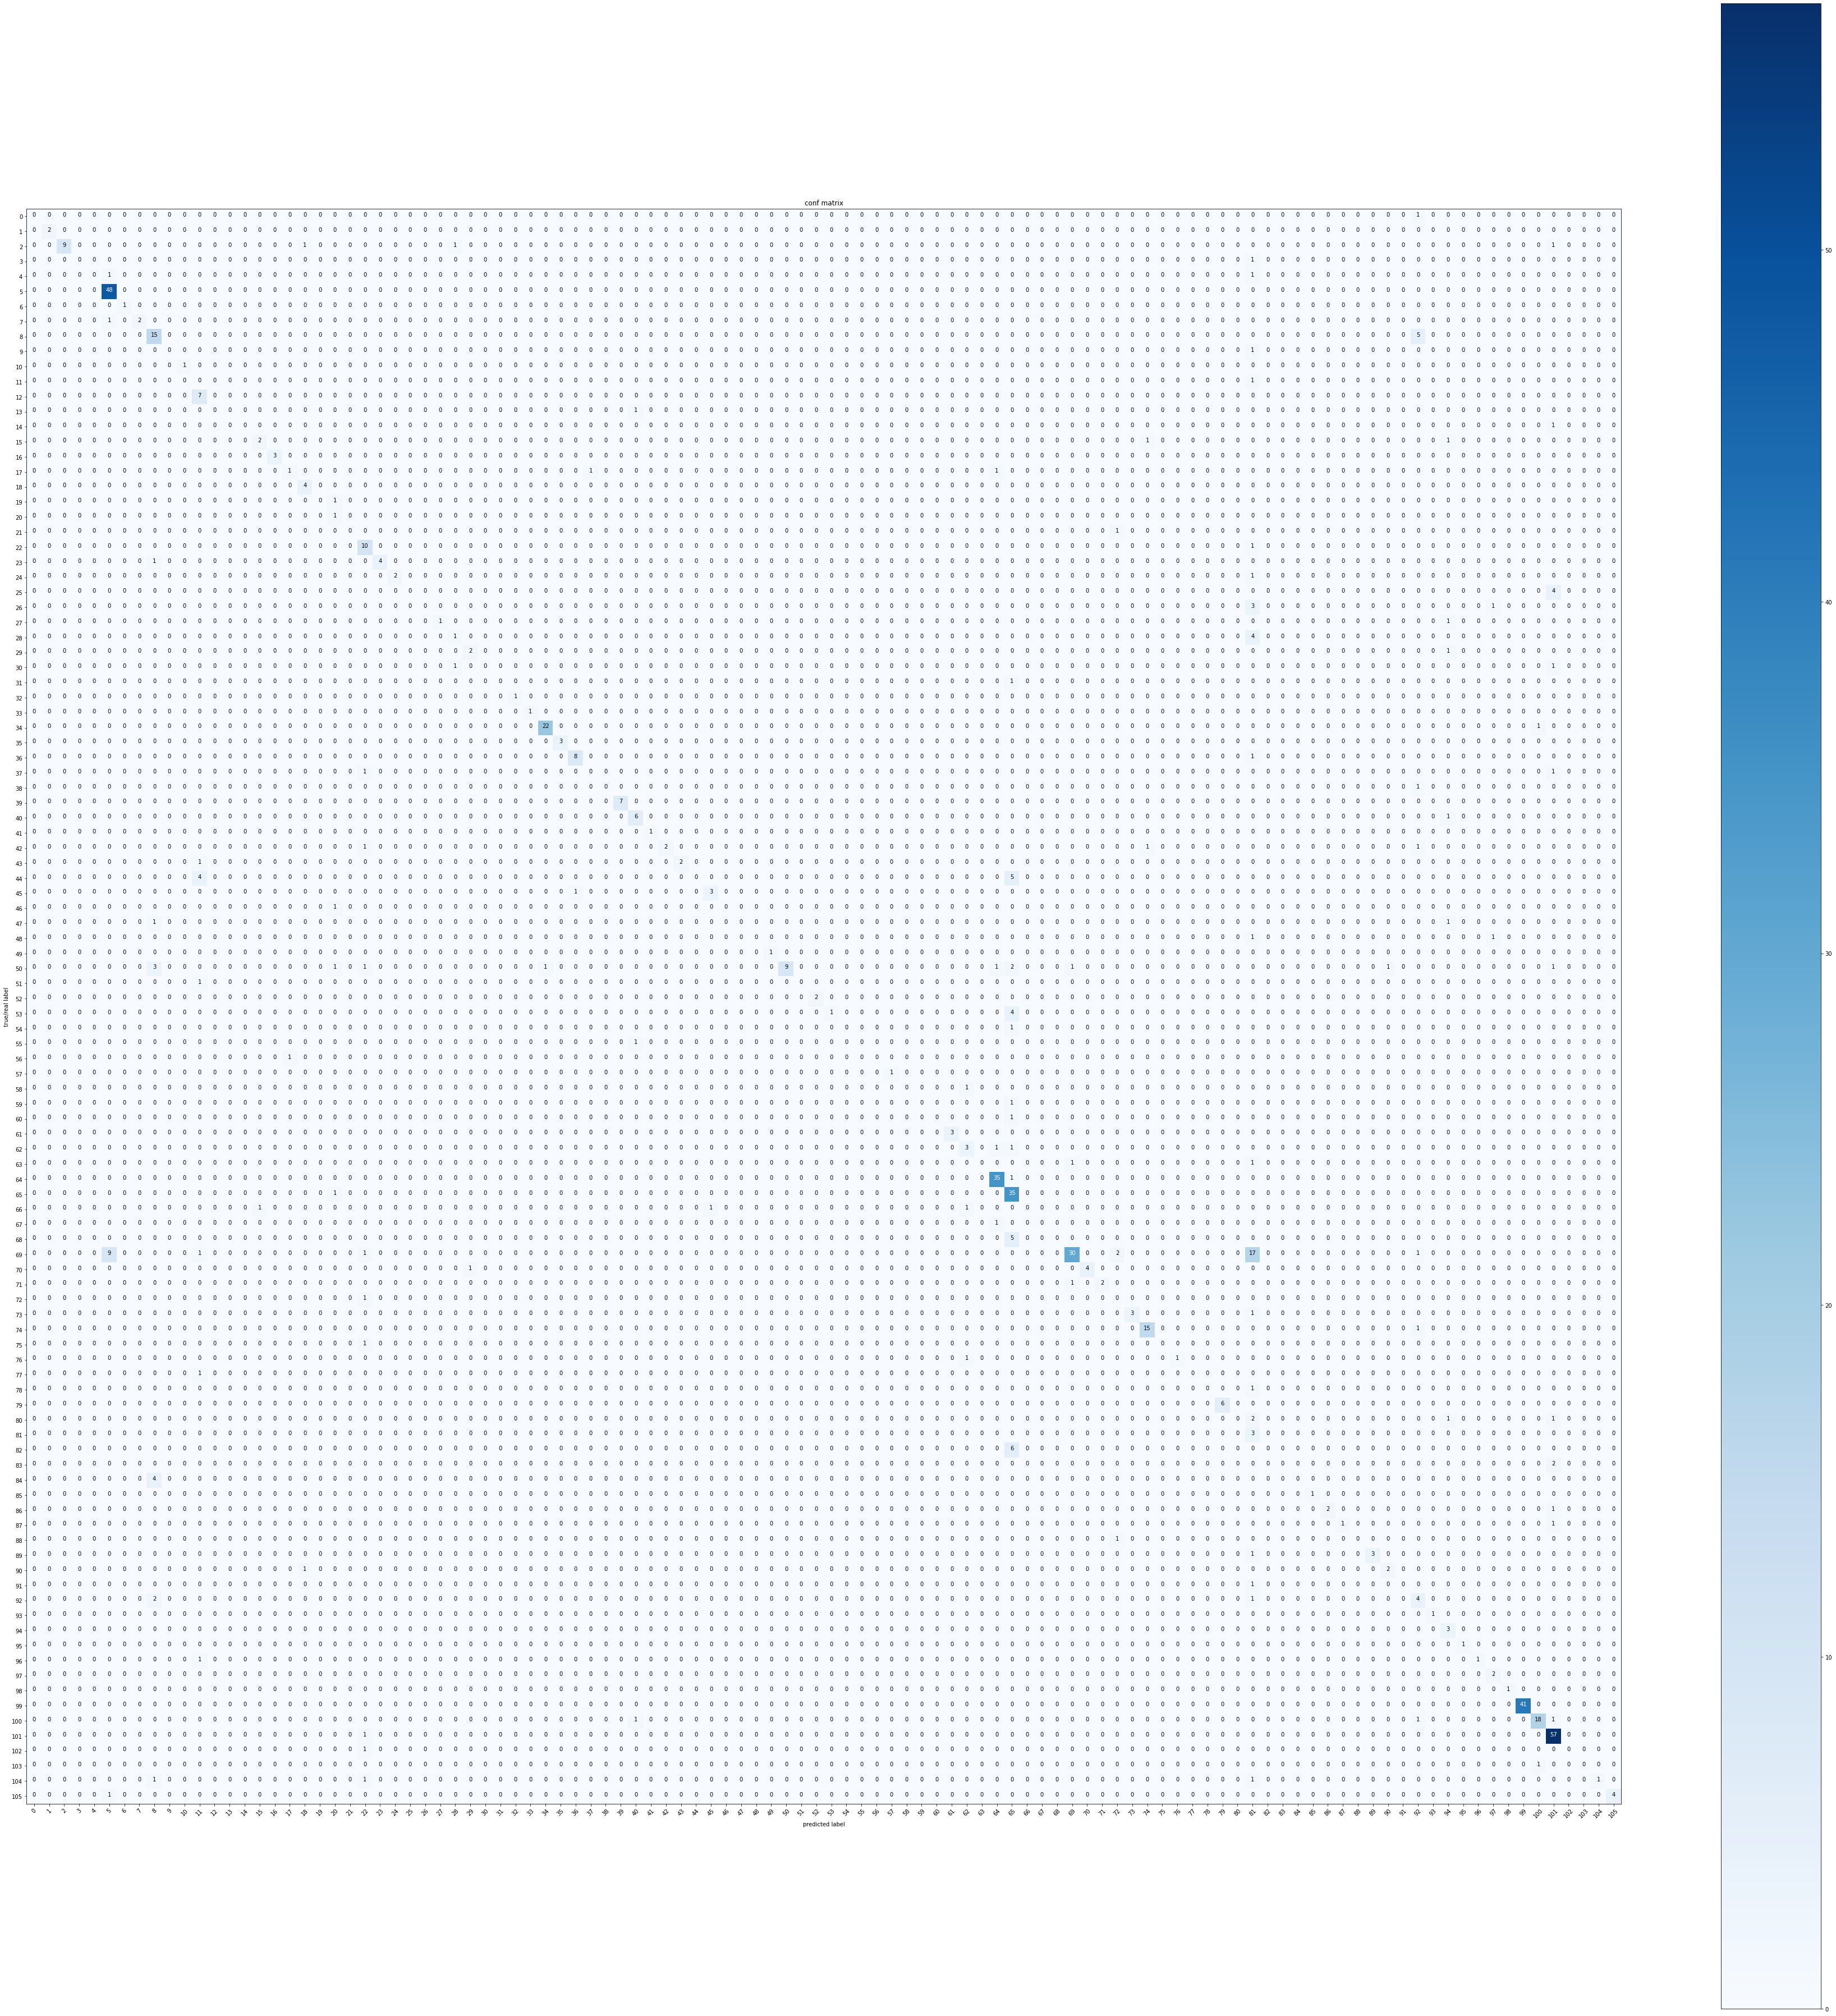

In [19]:
# cm_plot_labels=['0','1','2','3','4','5','6','7','8','9']
# cm_plot_labels=['0','1','2','3','4']
# cm_plot_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105]

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="conf matrix")

In [20]:
# model.save('mobileNet_model.h5')

In [21]:
# test_batches.class_indices

In [22]:
# imagePath='D:/senior year/GP/datasets/Dataset-Royals/test/Teti/Teti_6.jpg'
# test_image = image.load_img(imagePath, target_size = (224, 224)) 
# test_image = image.img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis = 0)

# #predict the result
# result = model.predict(test_image)
# print(result)


In [23]:
# from IPython.display import Image
# Image(filename='D:/senior year/GP/datasets/Dataset-Royals/test/Pepi-I/Pepi_I_8.jpg', width=150,height=100) 

In [24]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
# test_x=np.array(test_samples)
# y_pred=model.predict(test_x)
# y_pred=np.argmax(y_pred,axis=1)

y_pred=predictions.argmax(axis=1)
print(classification_report(y_pred,test_batches.classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00         2
           2       0.75      1.00      0.86         9
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      0.80      0.89        60
           6       1.00      1.00      1.00         1
           7       0.67      1.00      0.80         2
           8       0.75      0.56      0.64        27
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00         1
          11       0.00      0.00      0.00        16
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.50      0.67      0.57         3
          16       1.00      1.00      1.00         3
          17       0.33    

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


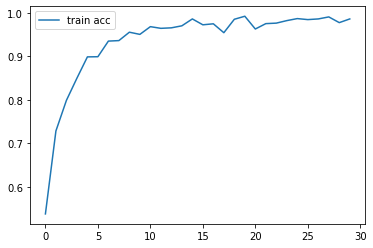

In [25]:
plt.plot(history.history['accuracy'], label='train acc')
# plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [26]:
import glob

train_image_names = glob.glob('D:/senior year/GP/datasets/ragaadataset/AFULL-CLASSES/dividing 106 classes 8020/train/*/*.png')
print("Total number of training images: ", len(train_image_names))

# make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

Total number of training images:  2585


In [27]:
test_image_names = glob.glob('D:/senior year/GP/datasets/ragaadataset/AFULL-CLASSES/dividing 106 classes 8020/test/*/*.png')
print("Total number of testing images: ", len(test_image_names))

# make train_image_names as serie object
test_image_names = pd.Series(test_image_names)

Total number of testing images:  651


In [28]:
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: int(float(img_name.split("\\")[-2])))

# train_df.head()


test_df = pd.DataFrame()
test_df['Filename'] = test_image_names.map(lambda img_name: img_name.split("/")[-1])
test_df['ClassId'] = test_image_names.map(lambda img_name: int(float(img_name.split("\\")[-2])))

In [29]:
class_id_distribution = train_df['ClassId'].value_counts()
class_id_distribution_test = test_df['ClassId'].value_counts()

#number of train images in each class
# for i in range(0,106):
#     print("class " +str(i) +" ---> " +str(class_id_distribution[i])  )

#number of test images in each class
# for i in range(0,106):
#     print("class " +str(i) +" ---> " +str(class_id_distribution_test[i])  )

<BarContainer object of 106 artists>

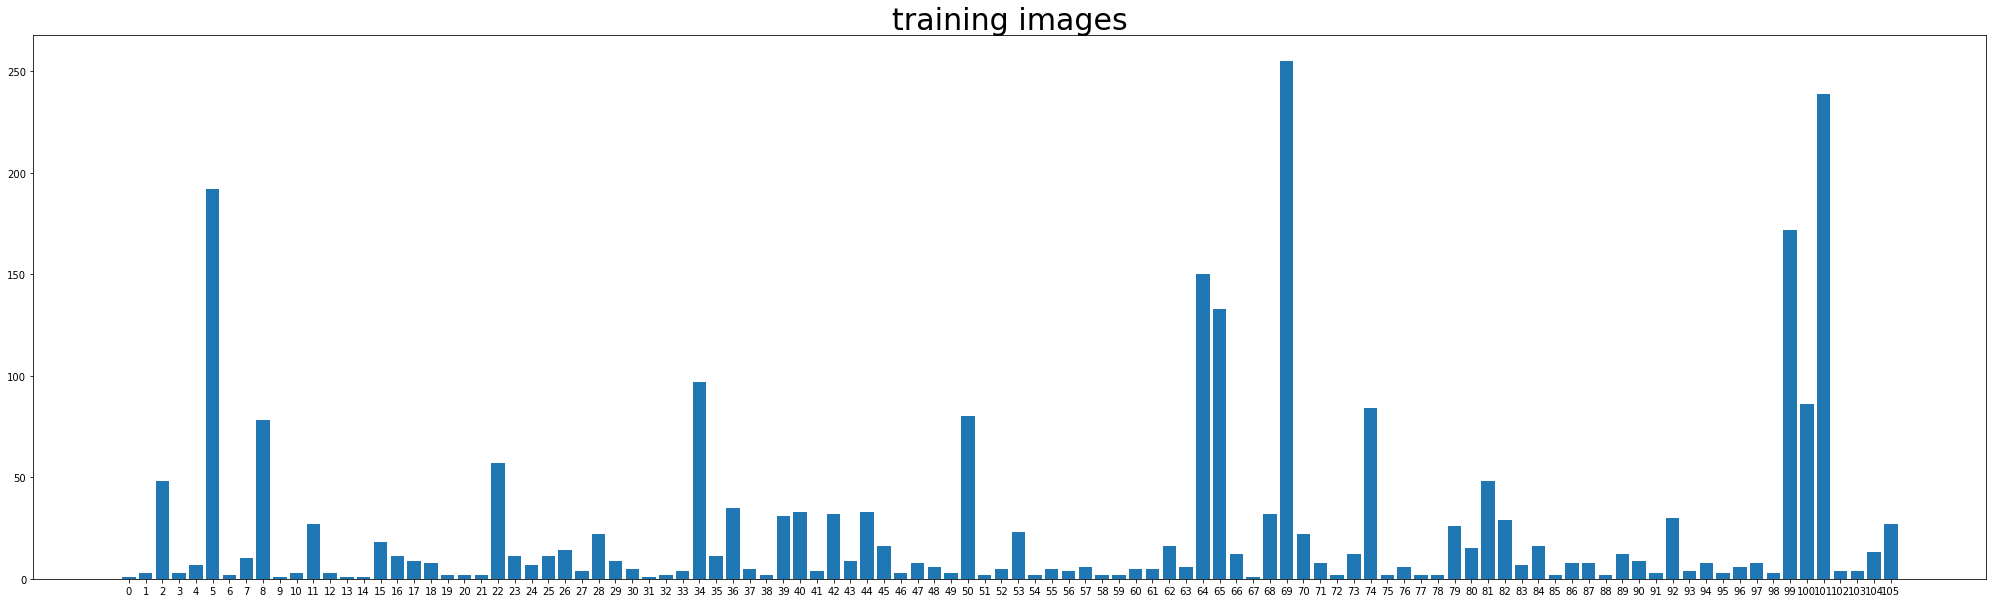

In [30]:
plt.figure(figsize=(35,10))
plt.xticks(np.arange(106))
plt.title("training images",  fontsize=30)
plt.bar(class_id_distribution.index, class_id_distribution.values)

<BarContainer object of 106 artists>

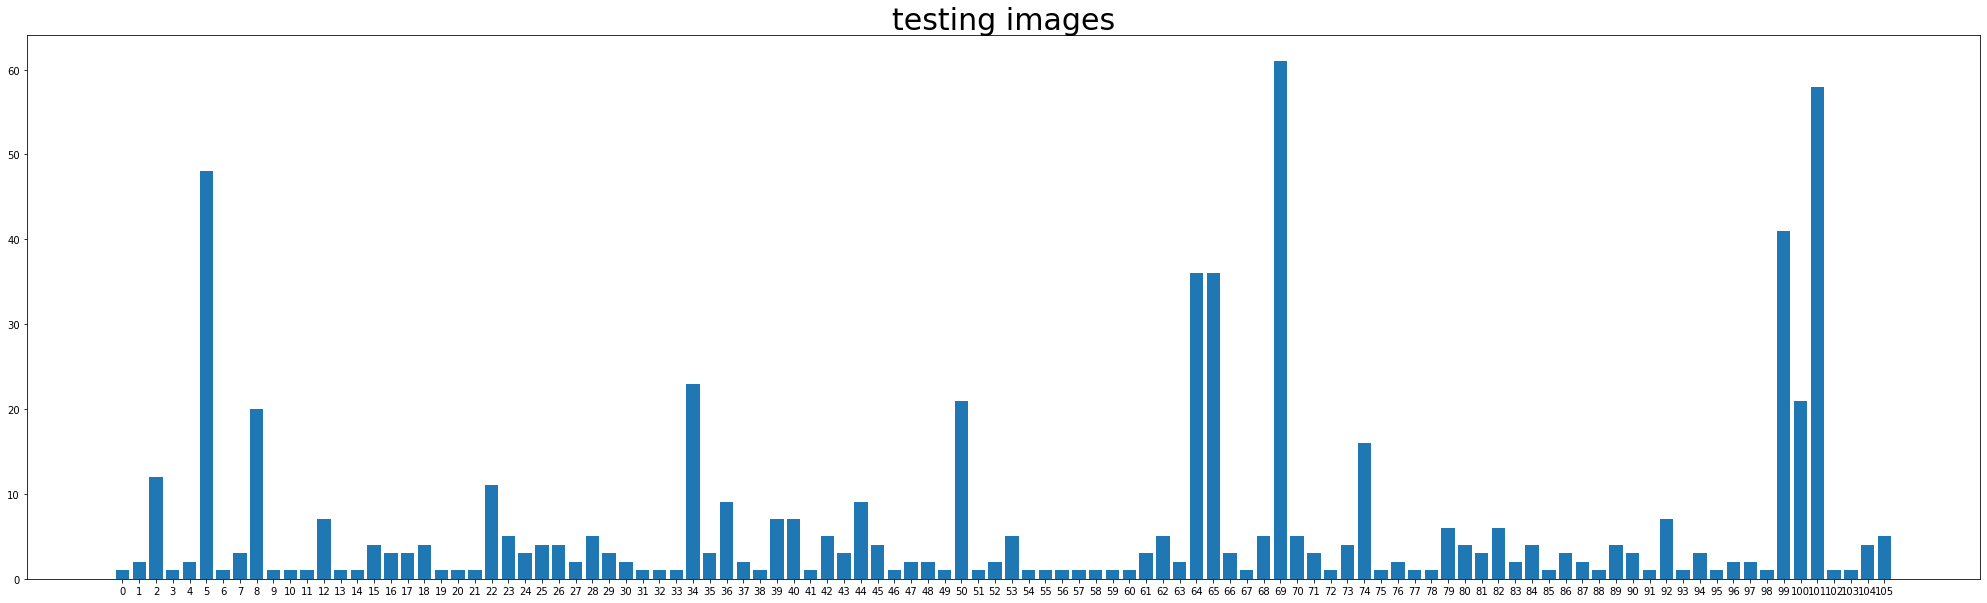

In [31]:
plt.figure(figsize=(35,10))
plt.xticks(np.arange(106))
plt.title("testing images",  fontsize=30)
plt.bar(class_id_distribution_test.index, class_id_distribution_test.values)

In [141]:
# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

In [ ]:

# img = image.load_img('D:/senior year/GP/datasets/ragaadataset/AFULL-CLASSES/dividing 106 classes 8020/train/000/220194_V6.png')  # this is a PIL image
# x = image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
# x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
# i = 0
# for batch in datagen.flow(train_batches, batch_size=1,
#                           save_to_dir='train', save_prefix='', save_format='png'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

In [37]:
# print(train_df.shape)
# print(test_df.shape)

(2585, 2)
(651, 2)


In [44]:
# df= pd.concat([train_image_names, test_image_names])
# df.shape

(3236,)

In [140]:
class_3=test_df[df['ClassId']==3]
class_3
# df['ClassId'].values

,Filename,ClassId
15,test\003\390267_V24.png,3


In [138]:
from sklearn.utils import resample
print("before resampling: ",test_df.shape)
# for i in range(0,106):

# print(test_df['ClassId'][0])
resample(class_0, n_samples = 30, replace = True, random_state = 42)


# print("after resampling: ",test_df.shape)


before resampling:  (651, 2)
after resampling:  (651, 2)


<BarContainer object of 106 artists>

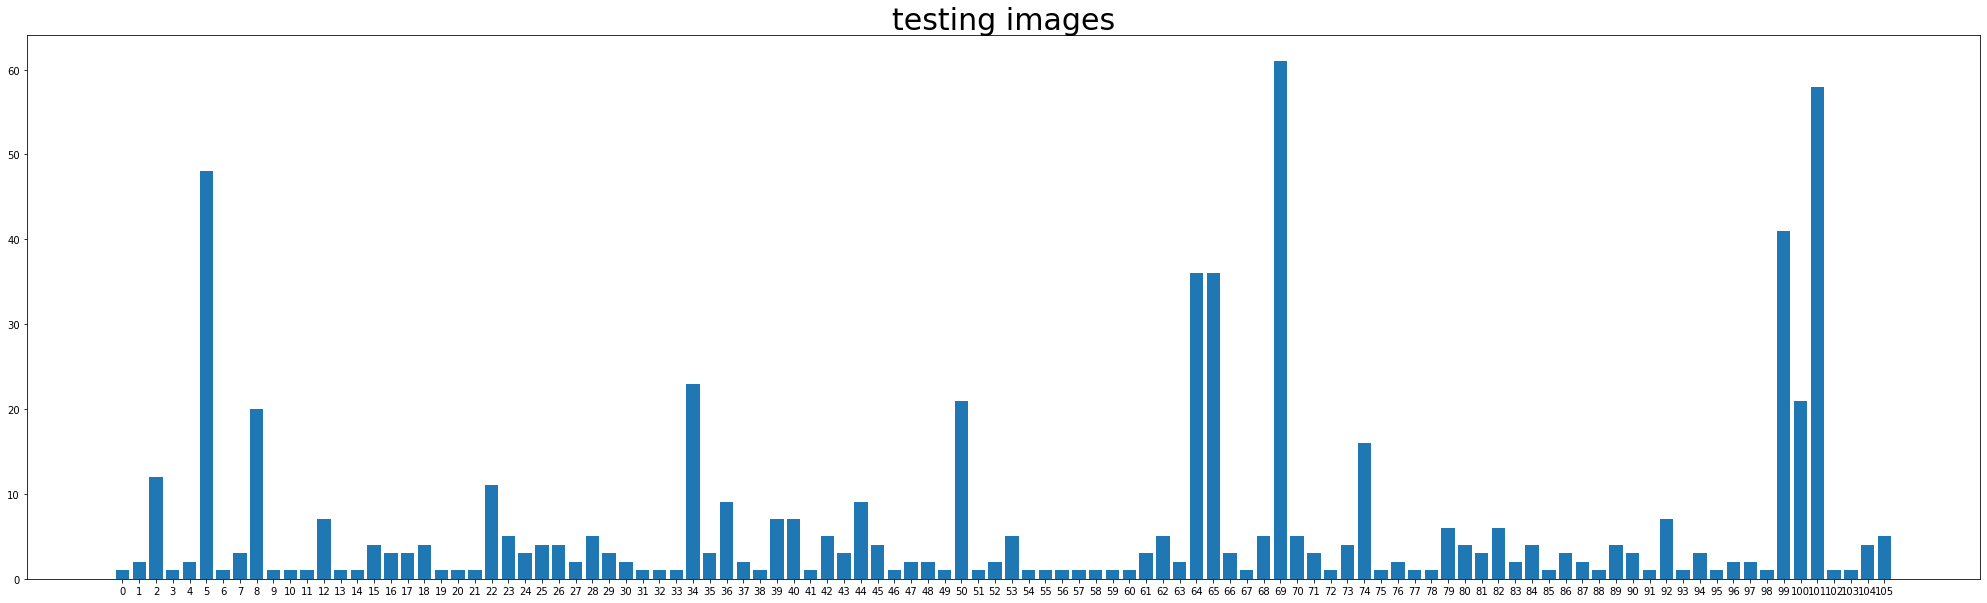

In [139]:
plt.figure(figsize=(35,10))
plt.xticks(np.arange(106))
plt.title("testing images",  fontsize=30)
plt.bar(class_id_distribution_test.index, class_id_distribution_test.values)